### Problem Statement

Internet based companies often receive lots of feedback from customers. To go through all the comments/reviews can often be a very long and tedious task. So, I tasked myself with categorizing the comments/reviews for the company's feedback management system so they can more easily focus on customer issues. We have to build a model that most accurately categorizes a review as positive, negative, or neutral.

Filtering through thousands of customer reviews can be a very long and arduous task for anyone, but is very important for the future of your product and ultimately your business. What if we you were able to categorize reviews so that you can immediately know if the customer has left a postive, neutral, or negative review? Utilizing my knowledge of Python and a Kaggle dataset, I apply machine learning models and figure out the most accurate machine learning algorithm to categorize musical instrument reviews left by customers.

## Dataset attributes
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review, e.g. 2/3
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review (raw)

**Libraries used**

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Musical_instruments_reviews.csv')

## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


Since we are analyzing only reviews ('reviewText') to predict the rating ('overall'), we will drop all the other columns.

In [4]:
df.drop(['reviewerID','asin','reviewerName','helpful','summary','unixReviewTime','reviewTime'],axis=1,inplace = True)

In [5]:
df.head(-10)

,reviewText,overall
0,"Not much to write about here, but it does exac...",5.0
1,The product does exactly as it should and is q...,5.0
2,The primary job of this device is to block the...,5.0
3,Nice windscreen protects my MXL mic and preven...,5.0
4,This pop filter is great. It looks and perform...,5.0
...,...,...
10246,I had the opportunity to try a set of Elixir N...,5.0
10247,"I was looking forward to trying these, as I've...",2.0
10248,I put these strings on my Guild acoustic elect...,5.0
10249,"I ordered this for my husband, the musician. ...",5.0


## Exploratory Data Analysis

#### Missing values

In [6]:
# Number of null values in dataset
df.isnull().sum()

reviewText    7
overall       0
dtype: int64

In [7]:
# Percentage of null values in dataset
(df.isnull().sum()/len(df))*100

reviewText    0.068219
overall       0.000000
dtype: float64

Since reviewText is missing such few entries, we can just drop the rows for which the data is missing. Also, the entries without reviewText would not be useful to run a model on.

In [8]:
df = df.dropna()

#### Outlier Search

In [9]:
# let's make a column that shows the length of each message
df['length'] = df['reviewText'].apply(len)

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
overall,10254.0,4.488492,0.894849,1.0,4.0,5.0,5.0,5.0
length,10254.0,486.260776,613.514024,9.0,163.0,285.0,552.0,11310.0


array([[<AxesSubplot:title={'center':'1.0'}>,
        <AxesSubplot:title={'center':'2.0'}>],
       [<AxesSubplot:title={'center':'3.0'}>,
        <AxesSubplot:title={'center':'4.0'}>],
       [<AxesSubplot:title={'center':'5.0'}>, <AxesSubplot:>]],
      dtype=object)

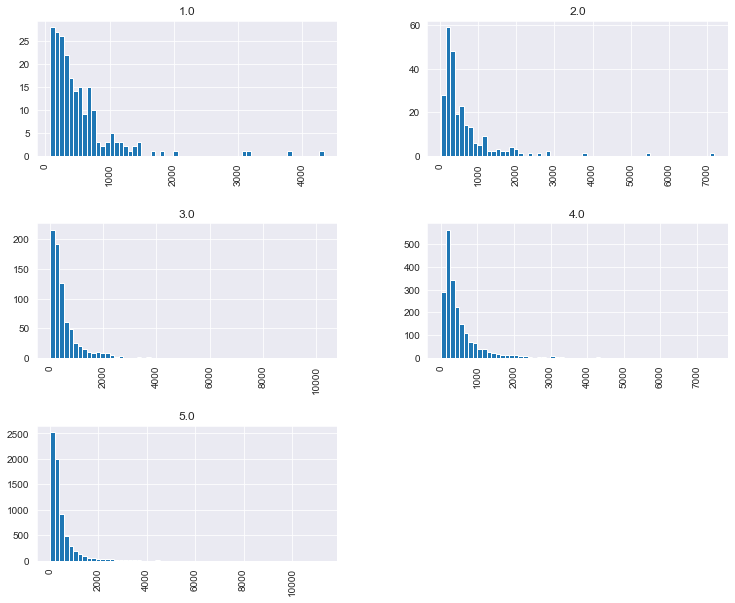

In [11]:
sns.set_style('darkgrid')
df.hist(column='length', by='overall', bins=60, figsize=(12,10))

It appears that most 5-star reviews are relatively short while 1-star reviews are longer. This makes sense because customers who are unhappy with their product will usually want to express their frustrations and why they don't like the product.

In [12]:
# What a long review... And it's a real review, too.
df[df['length']==11310]['reviewText'].iloc[0]

'COMPARISONS: I have compared, side by side, the following pedals:Fulltone mini deja vibe ($200), Dunlop Univibe (discontinued stainless steel model)($220), Dunlop Roto-vibe ($180), Voodoo Labs Micro Vibe ($150), BBE Soul Bender ($129) as well as comparing to some "different beasts" in the modulation family - an MXR phase 90, MXR EVH flanger, Boss chorus, Behringer Vibrato, and Behringer Time Machine.SUMMARY - just the factsA great pedal and my favorite uni-vibe of all. Doesn\'t take a lot of space up, standard power supply, good visibility on control knob settings. Does not add or subtract frequencies to the signal or add noise. This is the only pedal in the univibe group I can say that about and it\'s why it\'s almost certainly going to be the one I keep. Might have slightly less ability to produce as thick of a univibe effect as some of the others -- still need to play with it a little more. Overall I LOVE this pedal at under 60 bucks. Only downsides I see are the LED does not flash

In [13]:
df[df['length']==9]['reviewText'].iloc[0]

'excellent'

It appears that the reviews here are legit and that there aren't any outliers. 

In [14]:
df.drop('length',axis=1,inplace=True)

## Data Preprocessing

#### Numerical PreProcessing

I will remap the product ratings such that:
* positive (5 stars, 4 stars) $\to$ 2
* neutral (3 stars) $\to$ 1
* negative (2 stars, 1 star) $\to$ 0

In [15]:
# Remapping the ratings
df['overall'] = df['overall'].map({1.0:0, 2.0:0, 3.0:1, 4.0:2, 5.0:2})

#### Text PreProcessing

We will start to clean up our reviewText column by removing stopwords, removing punctuation, converting all text to lowercase, and lemmatizing all words to reduce word variability.

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Full list of English stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
# Building function to clean our text
from nltk.stem import WordNetLemmatizer
import string

lemmatizer = WordNetLemmatizer()
punctuation = list(string.punctuation)
stop = set(stopwords.words('english') + punctuation)
stop.update(punctuation)

def text_cleaner(messy):
    clean_text = []
    for word in messy.split():
        if word.lower() not in stop:
            lem = lemmatizer.lemmatize(word)
            clean_text.append(lem.lower())
    return " ".join(clean_text)

In [19]:
# Cleaning our text
df['reviewText'] = df['reviewText'].apply(text_cleaner)

## Vectorization and TFIDF

All machine learning models are some kind of mathematical model that need numbers to work with, so we will convert our text to numerical values. We will be using Term Frequency Inverse Document Frequency (TFIDF) Vectorizer to convert and sum all words per review to a numerical value. Then, we will use TF-IDF to assign a weight to each word per review. 

An example of this process has been given below.

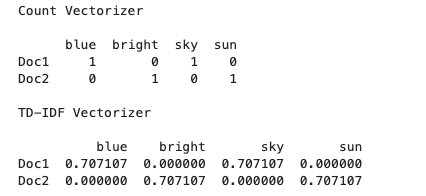

In [20]:
text_bag = TfidfVectorizer(max_features=5000,ngram_range=(2,2)).fit_transform(df['reviewText'])

In [21]:
print('Shape of sparse matrix: ', text_bag.shape)

Shape of sparse matrix:  (10254, 5000)


In [22]:
tfidf_transformer = TfidfTransformer().fit(text_bag)

In [23]:
review_tfidf = tfidf_transformer.transform(text_bag)

## Handling Target Imbalance with SMOTE

In [24]:
df['overall'].value_counts()

2    9015
1     772
0     467
Name: overall, dtype: int64

Text(0, 0.5, 'Count')

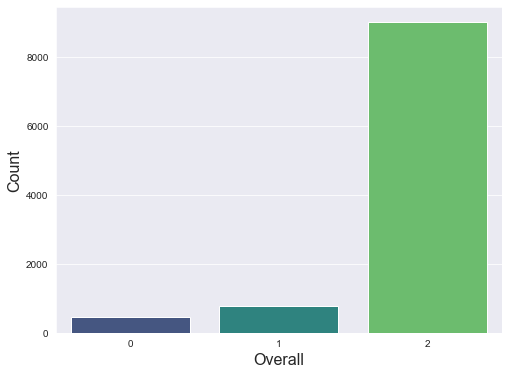

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(x='overall',data=df,palette='viridis')
plt.xlabel('Overall',fontsize=16)
plt.ylabel('Count',fontsize=16)

There are 9015 positive ratings, but only 772 neutral and 467 negative ratings. In a classification models, severely imbalanced classes like this usually leads to poor model performance. Therefore, I will be creating synthetic data that is relatively close and plausible to the minority classes such that there are 9015 positive, 9015 neutral, and 9015 negative ratings in the dataset. This allows for the model to learn more and become more accurate when predicting the neutral and negative ratings.

In [26]:
X = review_tfidf
y = df['overall']
oversampling_smote = SMOTE(sampling_strategy={1:9015, 0:9015})
undersampling = RandomUnderSampler(sampling_strategy={2:9015})
pipeline = Pipeline([('under', undersampling), ('over', oversampling_smote)])
df_train_resampled = pipeline.fit_resample(X, y)
X_smote = df_train_resampled[0] # Resampled X_train
y_smote = df_train_resampled[1] # Resample y_train

In [27]:
print(X_smote.shape)
print(y_smote.shape)

(27045, 5000)
(27045,)


## Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=101)

## Training and Evaluating Models

#### Multinomial Naive-Bayes

In [29]:
MNB = MultinomialNB()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(MNB,X_train,y_train,cv=KF,scoring='accuracy'))
print('MNB Accuracy: '+str(accuracy))

MNB Accuracy: 0.8327607821179331


#### Logistic Regression

In [30]:
LR = LogisticRegression()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(LR,X_train,y_train,cv=KF,scoring='accuracy'))
print('LR Accuracy: '+str(accuracy))

LR Accuracy: 0.863028940305276


#### Kernel Nearest Neighbor

In [31]:
KNN = KNeighborsClassifier()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(KNN,X_train,y_train,cv=KF,scoring='accuracy'))
print('KNN Accuracy: '+str(accuracy))

KNN Accuracy: 0.6235273423370831


We have very bad accuracy here, probably because the default value for K, which is 5, is not a good choice for this dataset. We will use the Elbow Method to find the optimal value for K.

In [32]:
#The Elbow Method for KNN
error_rate = []

for i in range(1,20):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,y_train)
    pred_i = KNN.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test)) # creating a list of error rates

([<matplotlib.axis.XTick at 0x1432f2ea730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

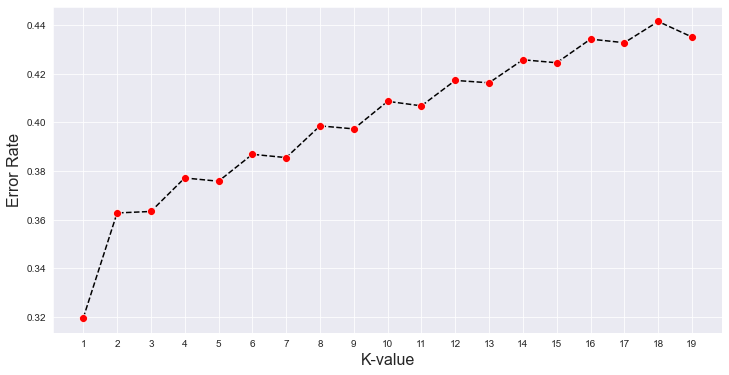

In [33]:
plt.figure(figsize = (12,6))
sns.lineplot(x=range(1,20), y=error_rate,color = 'black',marker='o',markerfacecolor = 'red',markersize = 8,ls='--')
plt.xlabel('K-value',fontsize=16)
plt.ylabel('Error Rate',fontsize=16)
plt.xticks(range(1,20))

We see that 1 is the optimal K-value because it has the lowest error rate.

In [34]:
KNN = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)
accuracy = np.mean(cross_val_score(KNN,X_train,y_train,cv=KF,scoring='accuracy'))
print('KNN Accuracy: '+str(accuracy))

KNN Accuracy: 0.6773015421986776


#### Support Vector Machine

In [35]:
SVM = SVC()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(SVM,X_train,y_train,cv=KF,scoring='accuracy'))
print('SVM Accuracy: ' + str(accuracy))

SVM Accuracy: 0.9646612518066157


#### Decision Tree

In [36]:
tree = DecisionTreeClassifier()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(tree,X_train,y_train,cv=KF,scoring='accuracy'))
print('Tree Accuracy: '+str(accuracy))

Tree Accuracy: 0.8509322841187587


#### Random Forest

In [37]:
rf = RandomForestClassifier()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(rf,X_train,y_train,cv=KF,scoring='accuracy'))
print('RF Accuracy: '+str(accuracy))

RF Accuracy: 0.8844223105402291


#### XGBoost

In [38]:
XGB = XGBClassifier()
KF = KFold(n_splits=5,shuffle=True,random_state=101)
accuracy = np.mean(cross_val_score(XGB,X_train,y_train,cv=KF,scoring='accuracy'))

print('XGB Accuracy: '+str(accuracy))

[16:48:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In this case, Support Vector Machine blew the competition out of the water with a 97.1% accuracy. Thus, we will move forward and begin hypertuning our SVM model using Grid Search.

## Hyperparameter Tuning

#### Grid Search

We will use Grid Search to find the optimal combination for the parameters 'C' and 'gamma'. Grid Search works by automatically trying every combination of given parameter and then choosing the combination with the highest score.

In [39]:
# Creating lists of possible parameters to test
parameter_grid = {'C':[1,2,3,4,5,6,7,8,9,10,11,12],'gamma':[100,10,1,0.1,0.01], 'kernel': ['rbf']}

In [40]:
grid = GridSearchCV(SVC(),parameter_grid,refit=True,cv=3,verbose=3)

In [41]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END .....................C=1, gamma=100, kernel=rbf; total time=  25.6s
[CV 2/3] END .....................C=1, gamma=100, kernel=rbf; total time=  25.1s
[CV 3/3] END .....................C=1, gamma=100, kernel=rbf; total time=  26.1s
[CV 1/3] END ......................C=1, gamma=10, kernel=rbf; total time=  17.8s
[CV 2/3] END ......................C=1, gamma=10, kernel=rbf; total time=  17.9s
[CV 3/3] END ......................C=1, gamma=10, kernel=rbf; total time=  18.5s
[CV 1/3] END .......................C=1, gamma=1, kernel=rbf; total time=  11.0s
[CV 2/3] END .......................C=1, gamma=1, kernel=rbf; total time=  11.0s
[CV 3/3] END .......................C=1, gamma=1, kernel=rbf; total time=  11.0s
[CV 1/3] END .....................C=1, gamma=0.1, kernel=rbf; total time=  12.2s
[CV 2/3] END .....................C=1, gamma=0.1, kernel=rbf; total time=  12.4s
[CV 3/3] END .....................C=1, gamma=0.

[CV 3/3] END .....................C=7, gamma=0.1, kernel=rbf; total time=   9.1s
[CV 1/3] END ....................C=7, gamma=0.01, kernel=rbf; total time=  15.9s
[CV 2/3] END ....................C=7, gamma=0.01, kernel=rbf; total time=  15.9s
[CV 3/3] END ....................C=7, gamma=0.01, kernel=rbf; total time=  15.9s
[CV 1/3] END .....................C=8, gamma=100, kernel=rbf; total time=  27.9s
[CV 2/3] END .....................C=8, gamma=100, kernel=rbf; total time=  26.6s
[CV 3/3] END .....................C=8, gamma=100, kernel=rbf; total time=  27.1s
[CV 1/3] END ......................C=8, gamma=10, kernel=rbf; total time=  17.7s
[CV 2/3] END ......................C=8, gamma=10, kernel=rbf; total time=  16.3s
[CV 3/3] END ......................C=8, gamma=10, kernel=rbf; total time=  16.5s
[CV 1/3] END .......................C=8, gamma=1, kernel=rbf; total time=   8.4s
[CV 2/3] END .......................C=8, gamma=1, kernel=rbf; total time=   8.5s
[CV 3/3] END ...............

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'gamma': [100, 10, 1, 0.1, 0.01], 'kernel': ['rbf']},
             verbose=3)

In [42]:
grid.best_params_

{'C': 7, 'gamma': 1, 'kernel': 'rbf'}

#### Building the Model

In [46]:
SVM = SVC(C=7,gamma=1,kernel='rbf')
SVM.fit(X_train,y_train)
predictions = SVM.predict(X_test)

#### Measuring Model Performance

In [47]:
print('SVM Train Accuracy: ' + str(SVM.score(X_train,y_train)))
print('SVM Test Accuracy: ' + str(SVM.score(X_test,y_test)))
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

SVM Train Accuracy: 0.97575405419682
SVM Test Accuracy: 0.9726398816859748
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2693
           1       0.99      0.95      0.97      2661
           2       1.00      0.97      0.98      2760

    accuracy                           0.97      8114
   macro avg       0.97      0.97      0.97      8114
weighted avg       0.97      0.97      0.97      8114

[[2690    1    2]
 [ 137 2515    9]
 [  59   14 2687]]


## Conclusion

After thorough testing, Support Vector Machine is unquestionably the best model for this data. With it, we were able to achieve:

* A minimum precision score of 91%
* A minimum recall score of 93%
* An overall accuracy of 97%

In order to get these scores, we had to had to clean the data, manipulate it, and rebalance it using SMOTE. This certainly isn't a completely exhaustive analysis of this dataset, but there is more to learn.

Thank you for reading!